# ANN Regression

**Autores:** [Lucas Lima](https://github.com/lucasouzamil), [Henrique Badin](https://github.com/henriquefbadin) e [Eduardo Selber](https://github.com/eduselber).

**Dataset Escolhido:** [Fligt Price Prediction](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction).

**Notebook De Referência:** [Flight Price Prediction | EDA | Regression & ANN](https://www.kaggle.com/code/tunaeem/flight-price-prediction-eda-regression-ann)

## Descrição do Conjunto de Dados

O conjunto de dados contém informações sobre passagens aéreas obtidas do site **EaseMyTrip**, com o objetivo de analisar fatores que influenciam o **preço das passagens** e treinar um modelo de **regressão linear** para previsão. Foram coletados **300.261 registros** entre **11 de fevereiro e 31 de março de 2022**, abrangendo voos entre as **seis principais cidades da Índia**.

## Estrutura do Dataset

O conjunto possui **11 variáveis**, sendo **10 preditoras** e **1 alvo (Price)**:

| Variável         | Tipo              | Descrição                                |
| ---------------- | ----------------- | ---------------------------------------- |
| Airline          | Categórica        | Companhia aérea (6 valores únicos)       |
| Flight           | Categórica        | Código do voo                            |
| Source City      | Categórica        | Cidade de origem                         |
| Departure Time   | Categórica        | Faixa de horário de partida              |
| Stops            | Categórica        | Número de escalas                        |
| Arrival Time     | Categórica        | Faixa de horário de chegada              |
| Destination City | Categórica        | Cidade de destino                        |
| Class            | Categórica        | Classe da passagem (Economy ou Business) |
| Duration         | Numérica contínua | Duração do voo em horas                  |
| Days Left        | Numérica discreta | Dias entre a compra e a data do voo      |
| Price            | Numérica contínua | **Variável alvo** – preço da passagem    |

### Tipos de Variáveis

* **Categóricas nominais:** Airline, Flight, Source City, Destination City, Class
* **Categóricas ordinais:** Departure Time, Arrival Time, Stops
* **Numéricas:** Duration, Days Left, Price


## Dataset Observation

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [56]:
df = pd.read_csv("data/Clean_Dataset.csv")
df = df.drop(['Unnamed: 0'], axis = 1)
print("\n================== HEAD DO DATASET ==================\n")
display(df.head())
print("\n=====================================================\n")
print("\n================== SHAPE DO DATASET ==================\n")
display(df.shape)
print("\n=====================================================\n")
display(df.dtypes)
print("\n================== VISUALIZANDO VALORES NULOS ==================\n")
null_summary = df.isnull().sum().to_frame().rename(columns={0: 'Null Count'})
null_summary['Percentage'] = (null_summary['Null Count'] / len(df)) * 100
display(null_summary)
print("\n=====================================================\n")


================== HEAD DO DATASET ==================



,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955





================== SHAPE DO DATASET ==================



(300153, 11)

airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object


================== VISUALIZANDO VALORES NULOS ==================



,Null Count,Percentage
airline,0,0.0
flight,0,0.0
source_city,0,0.0
departure_time,0,0.0
stops,0,0.0
arrival_time,0,0.0
destination_city,0,0.0
class,0,0.0
duration,0,0.0
days_left,0,0.0


Na primeira breve análise, o dataset não possui valores nulos, há várias variáveis categóricas que precisam ser tratadas e o target é numérico contínuo.

### Análise das variáveis categóricas

In [19]:
# Todas possíveis variáveis categóricas
cat_features = [column for column in df.columns if df[column].dtype in ["object", "category", "bool"]]

# Numéricas mas na verdade são categóricas
num_but_cat_features = [column for column in df.columns if (df[column].dtype in ["int64", "float64"]) and (df[column].nunique() < 9)]

# Variáveis categóricas
categoric_features = cat_features + num_but_cat_features
categoric_features = [column for column in categoric_features]

df[categoric_features]

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy
...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business


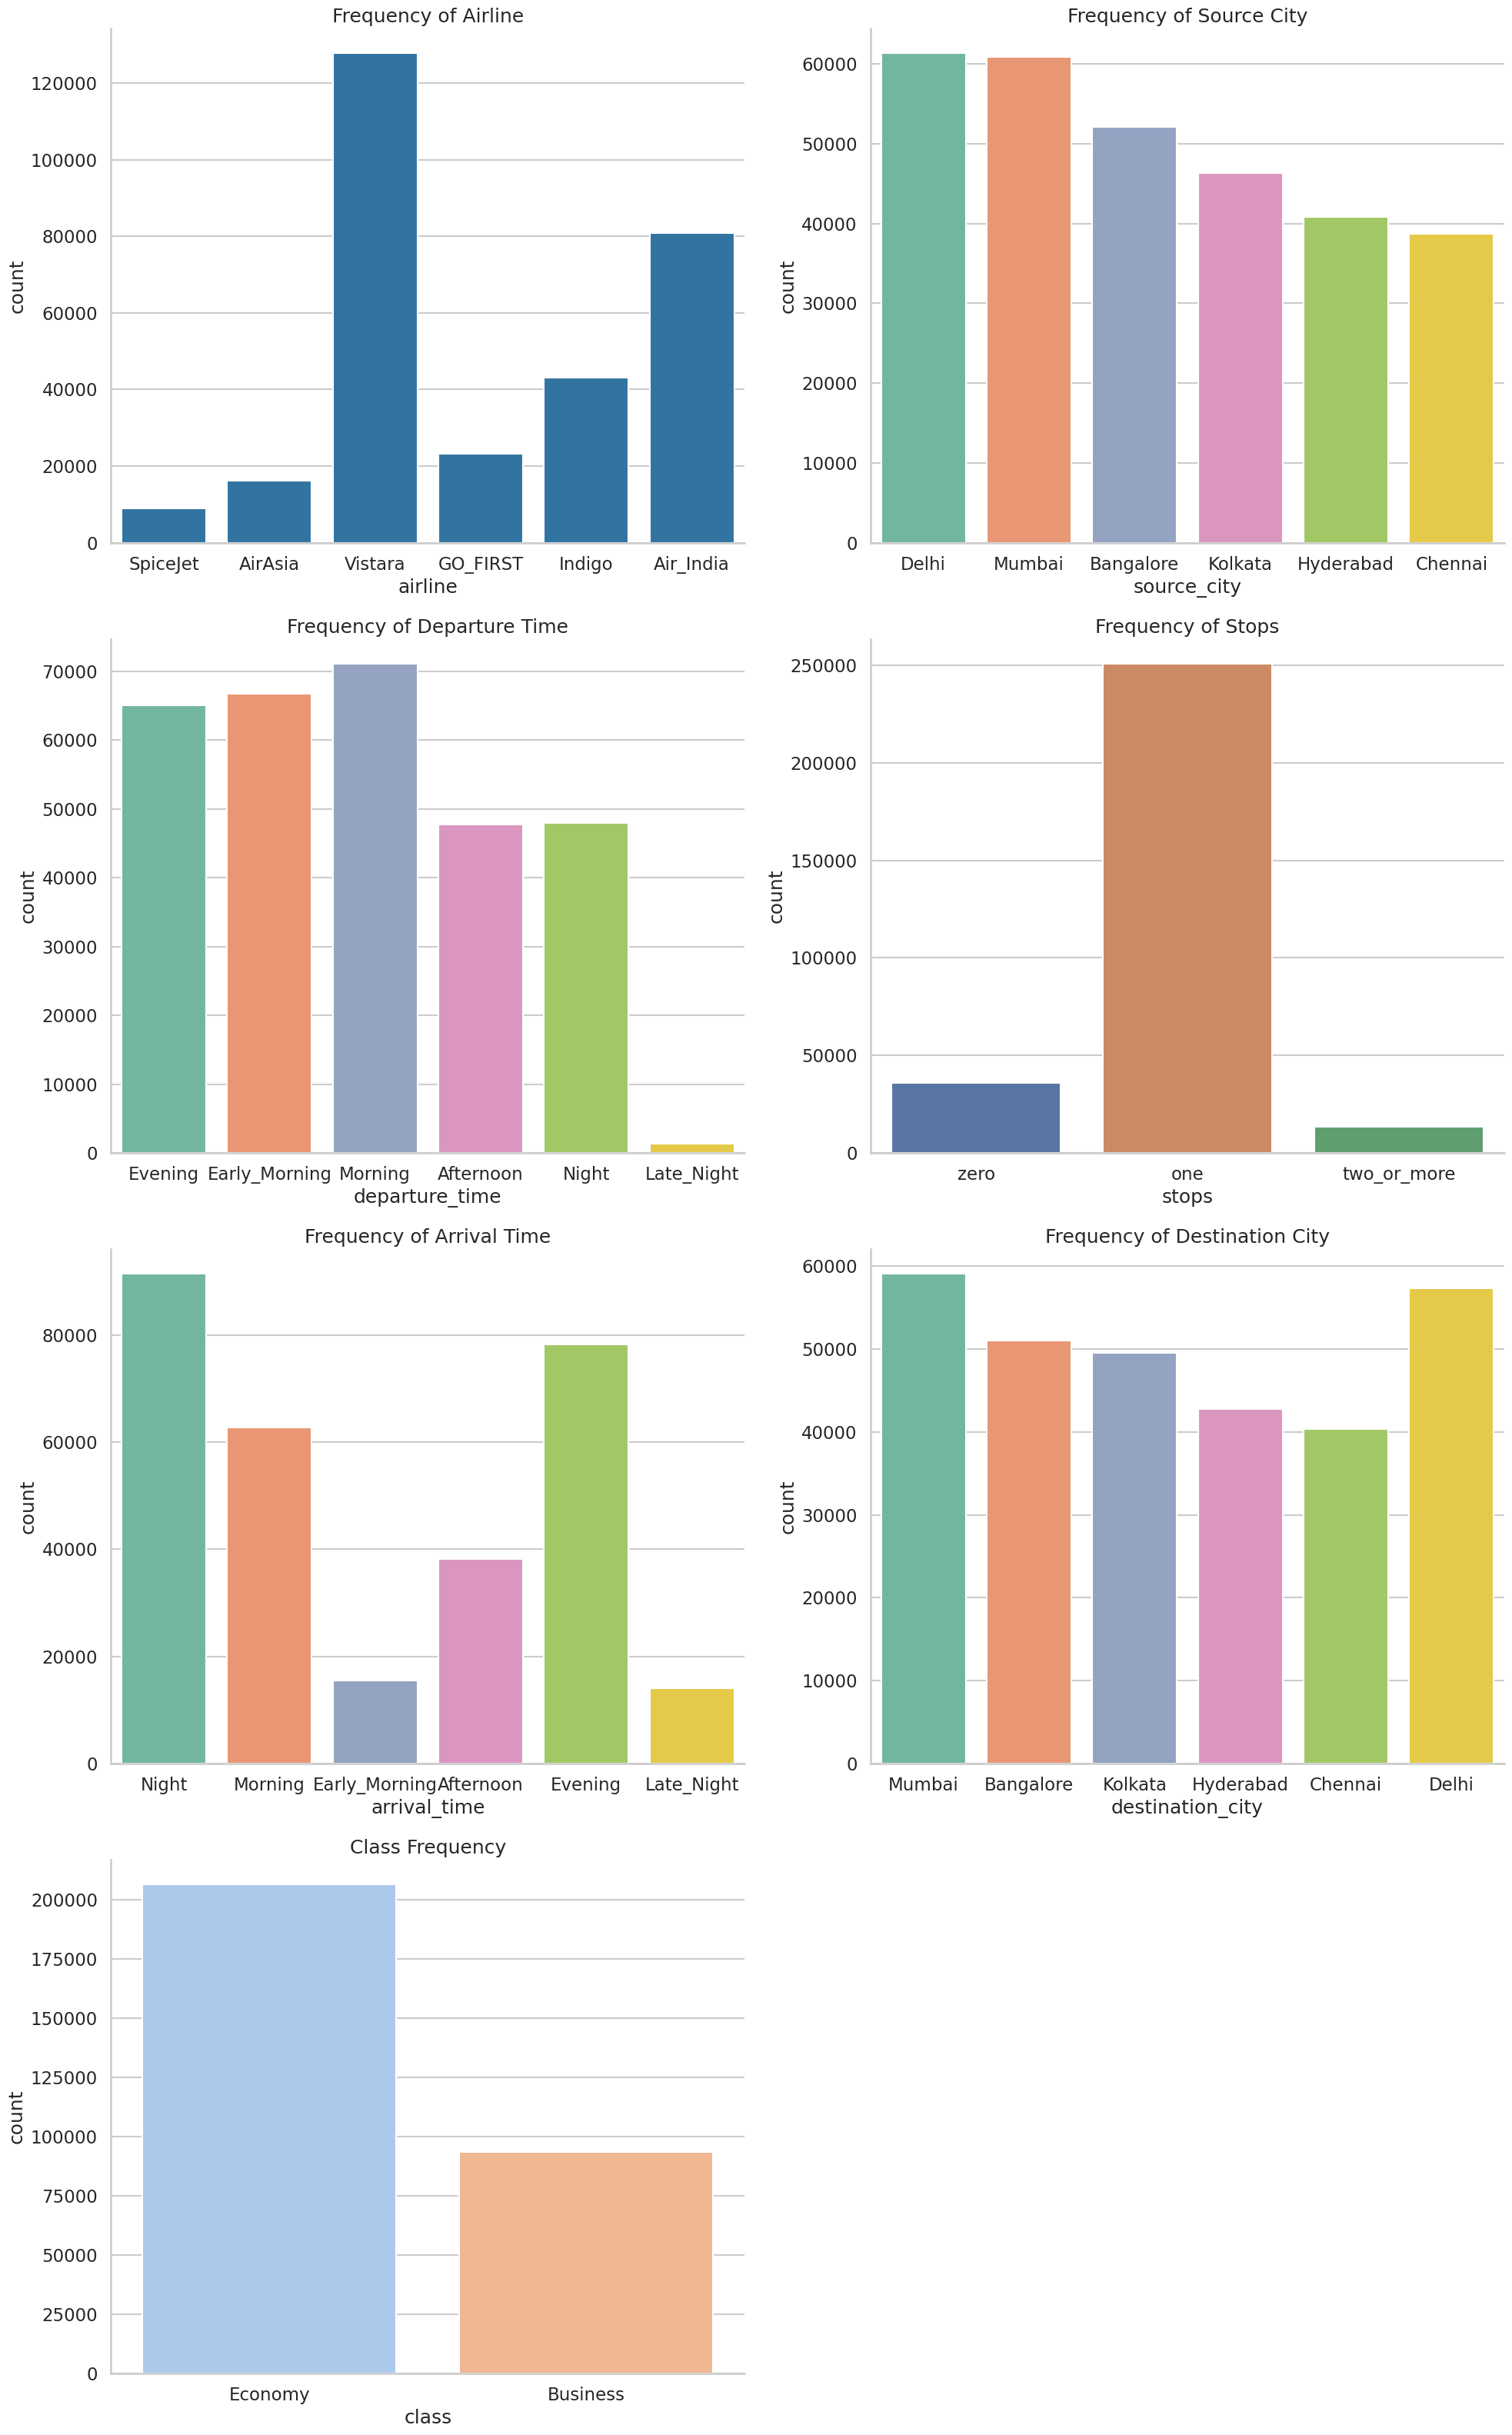

In [ ]:
sns.set_style("whitegrid")
sns.set_context("talk") 
palette_colors = "Set2" 

plt.figure(figsize=(20,32))

plt.subplot(4, 2, 1)
sns.countplot(x=df["airline"], data=df, legend=False)
plt.title("Frequency of Airline")
sns.despine() 

plt.subplot(4, 2, 2)
sns.countplot(x=df["source_city"], data=df, palette=palette_colors, 
              hue=df["source_city"], legend=False) 
plt.title("Frequency of Source City")
sns.despine() 

plt.subplot(4, 2, 3)
sns.countplot(x=df["departure_time"], data=df, palette=palette_colors, 
              hue=df["departure_time"], legend=False)
plt.title("Frequency of Departure Time")
sns.despine() 

plt.subplot(4, 2, 4)
sns.countplot(x=df["stops"], data=df, palette="deep", 
              hue=df["stops"], legend=False) 
plt.title("Frequency of Stops")
sns.despine() 

plt.subplot(4, 2, 5)
sns.countplot(x=df["arrival_time"], data=df, palette=palette_colors, 
              hue=df["arrival_time"], legend=False)
plt.title("Frequency of Arrival Time")
sns.despine() 

plt.subplot(4, 2, 6)
sns.countplot(x=df["destination_city"], data=df, palette=palette_colors, 
              hue=df["destination_city"], legend=False)
plt.title("Frequency of Destination City")
sns.despine() 

plt.subplot(4, 2, 7)
sns.countplot(x=df["class"], data=df, palette="pastel", 
              hue=df["class"], legend=False) 
plt.title("Class Frequency")
sns.despine() 

plt.tight_layout() 
plt.show()

### Análise das variáveis numéricas

In [20]:
numeric_features = [column for column in df.columns if (df[column].dtype in ["int64", "float64"]) and (column not in categoric_features)]

df[numeric_features]

,duration,days_left,price
0,2.17,1,5953
1,2.33,1,5953
2,2.17,1,5956
3,2.25,1,5955
4,2.33,1,5955
...,...,...,...
300148,10.08,49,69265
300149,10.42,49,77105
300150,13.83,49,79099
300151,10.00,49,81585


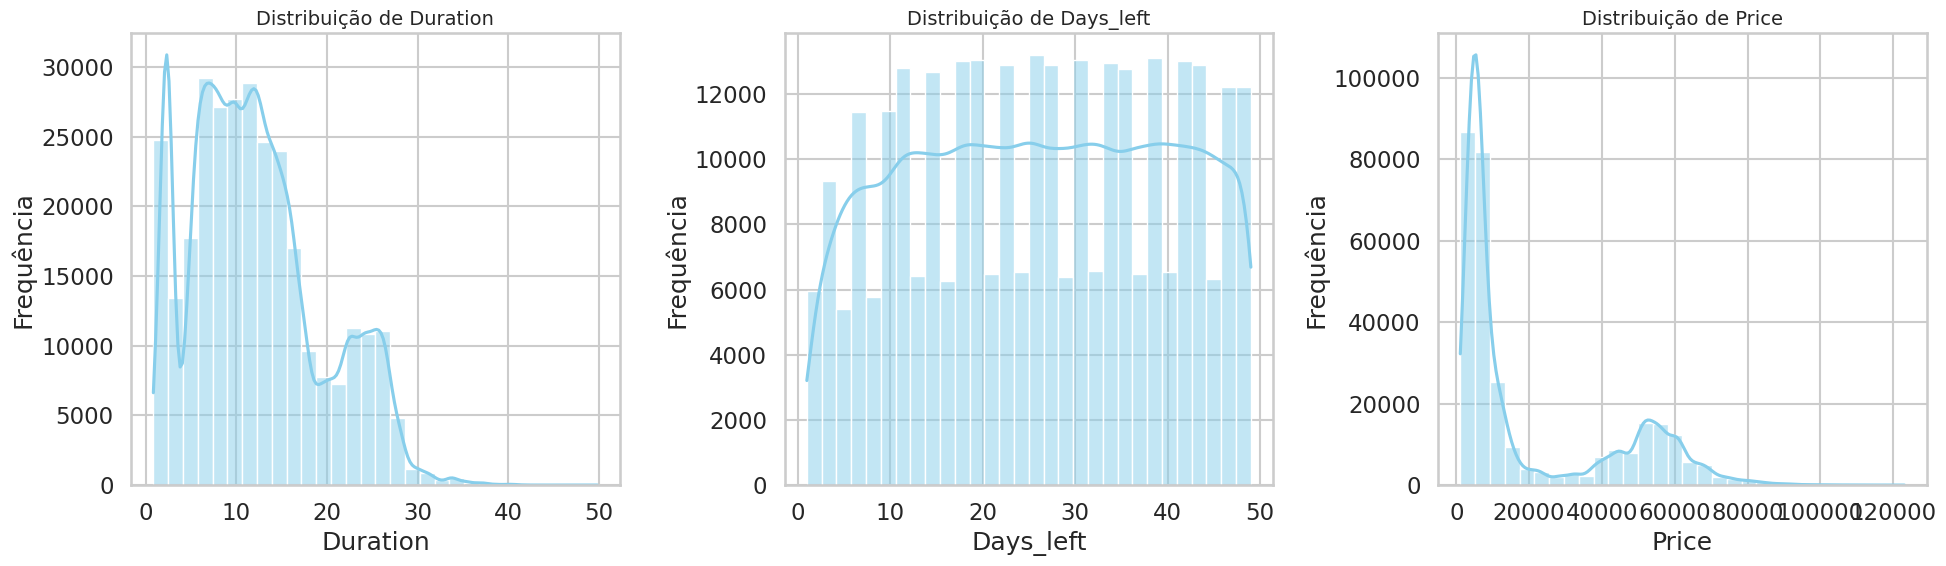

In [25]:
plt.figure(figsize=(20,6))

for i, col in enumerate(["duration", "days_left", "price"], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, color="skyblue", bins=30)
    plt.title(f"Distribuição de {col.capitalize()}", fontsize=14)
    plt.xlabel(col.capitalize())
    plt.ylabel("Frequência")

plt.tight_layout()
plt.show()


### Análise de correlação da variável target

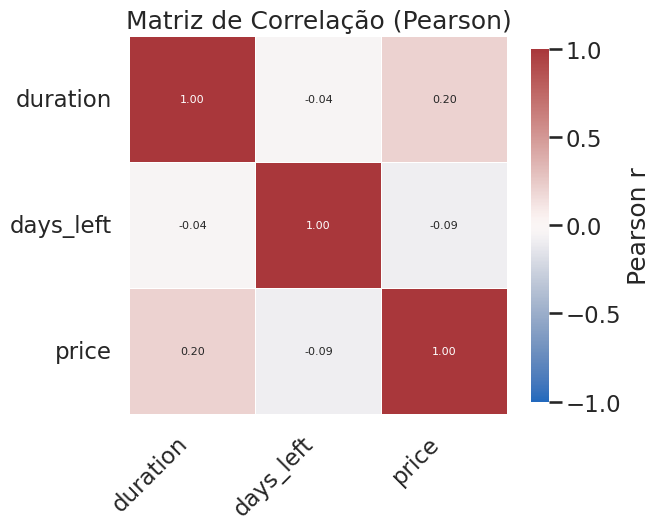

In [30]:
corr = df[
    [c for c in numeric_features if not c.startswith('Unnamed')]
].corr()

plt.figure(figsize=(7, 6))

cmap = sns.color_palette("vlag", as_cmap=True) 

ax = sns.heatmap(
    corr,
    cmap=cmap,
    vmin=-1, vmax=1, center=0,       
    annot=True, fmt=".2f",            
    annot_kws={"size":8},
    square=True,
    linewidths=0.4, linecolor="white",
    cbar_kws={"shrink":0.8, "label":"Pearson r"},
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Matriz de Correlação (Pearson)")
plt.tight_layout()
plt.show()

## Pré Processamento

Uma vez que "stop" e "class" são variáveis orinárias, o encoding também deve ser de acordo.

In [31]:
df["stops"] = df["stops"].replace({'zero': 0,
                                   'one': 1,
                                   'two_or_more': 2})

df["class"] = df["class"].replace({'Economy': 0,
                                   'Business': 1})

/tmp/ipykernel_87733/3553766138.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["stops"] = df["stops"].replace({'zero': 0,
/tmp/ipykernel_87733/3553766138.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["class"] = df["class"].replace({'Economy': 0,


In [ ]:
# One Hot Encoding
dummies_variables = ["airline", "source_city", "departure_time", "arrival_time", "destination_city"]
dummies = pd.get_dummies(df[dummies_variables], drop_first= True)

df = pd.concat([df, dummies], axis=1)
df = df.drop(dummies_variables + ['flight'], axis=1) # Excluindo colunas antigas antes do one hot.

df.head()

,stops,class,duration,days_left,price,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,...,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,0,0,2.17,1,5953,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
1,0,0,2.33,1,5953,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
2,0,0,2.17,1,5956,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
3,0,0,2.25,1,5955,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4,0,0,2.33,1,5955,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True


In [33]:
df.shape

(300153, 30)

Após o one hot, 18 novas featutes surgiram.

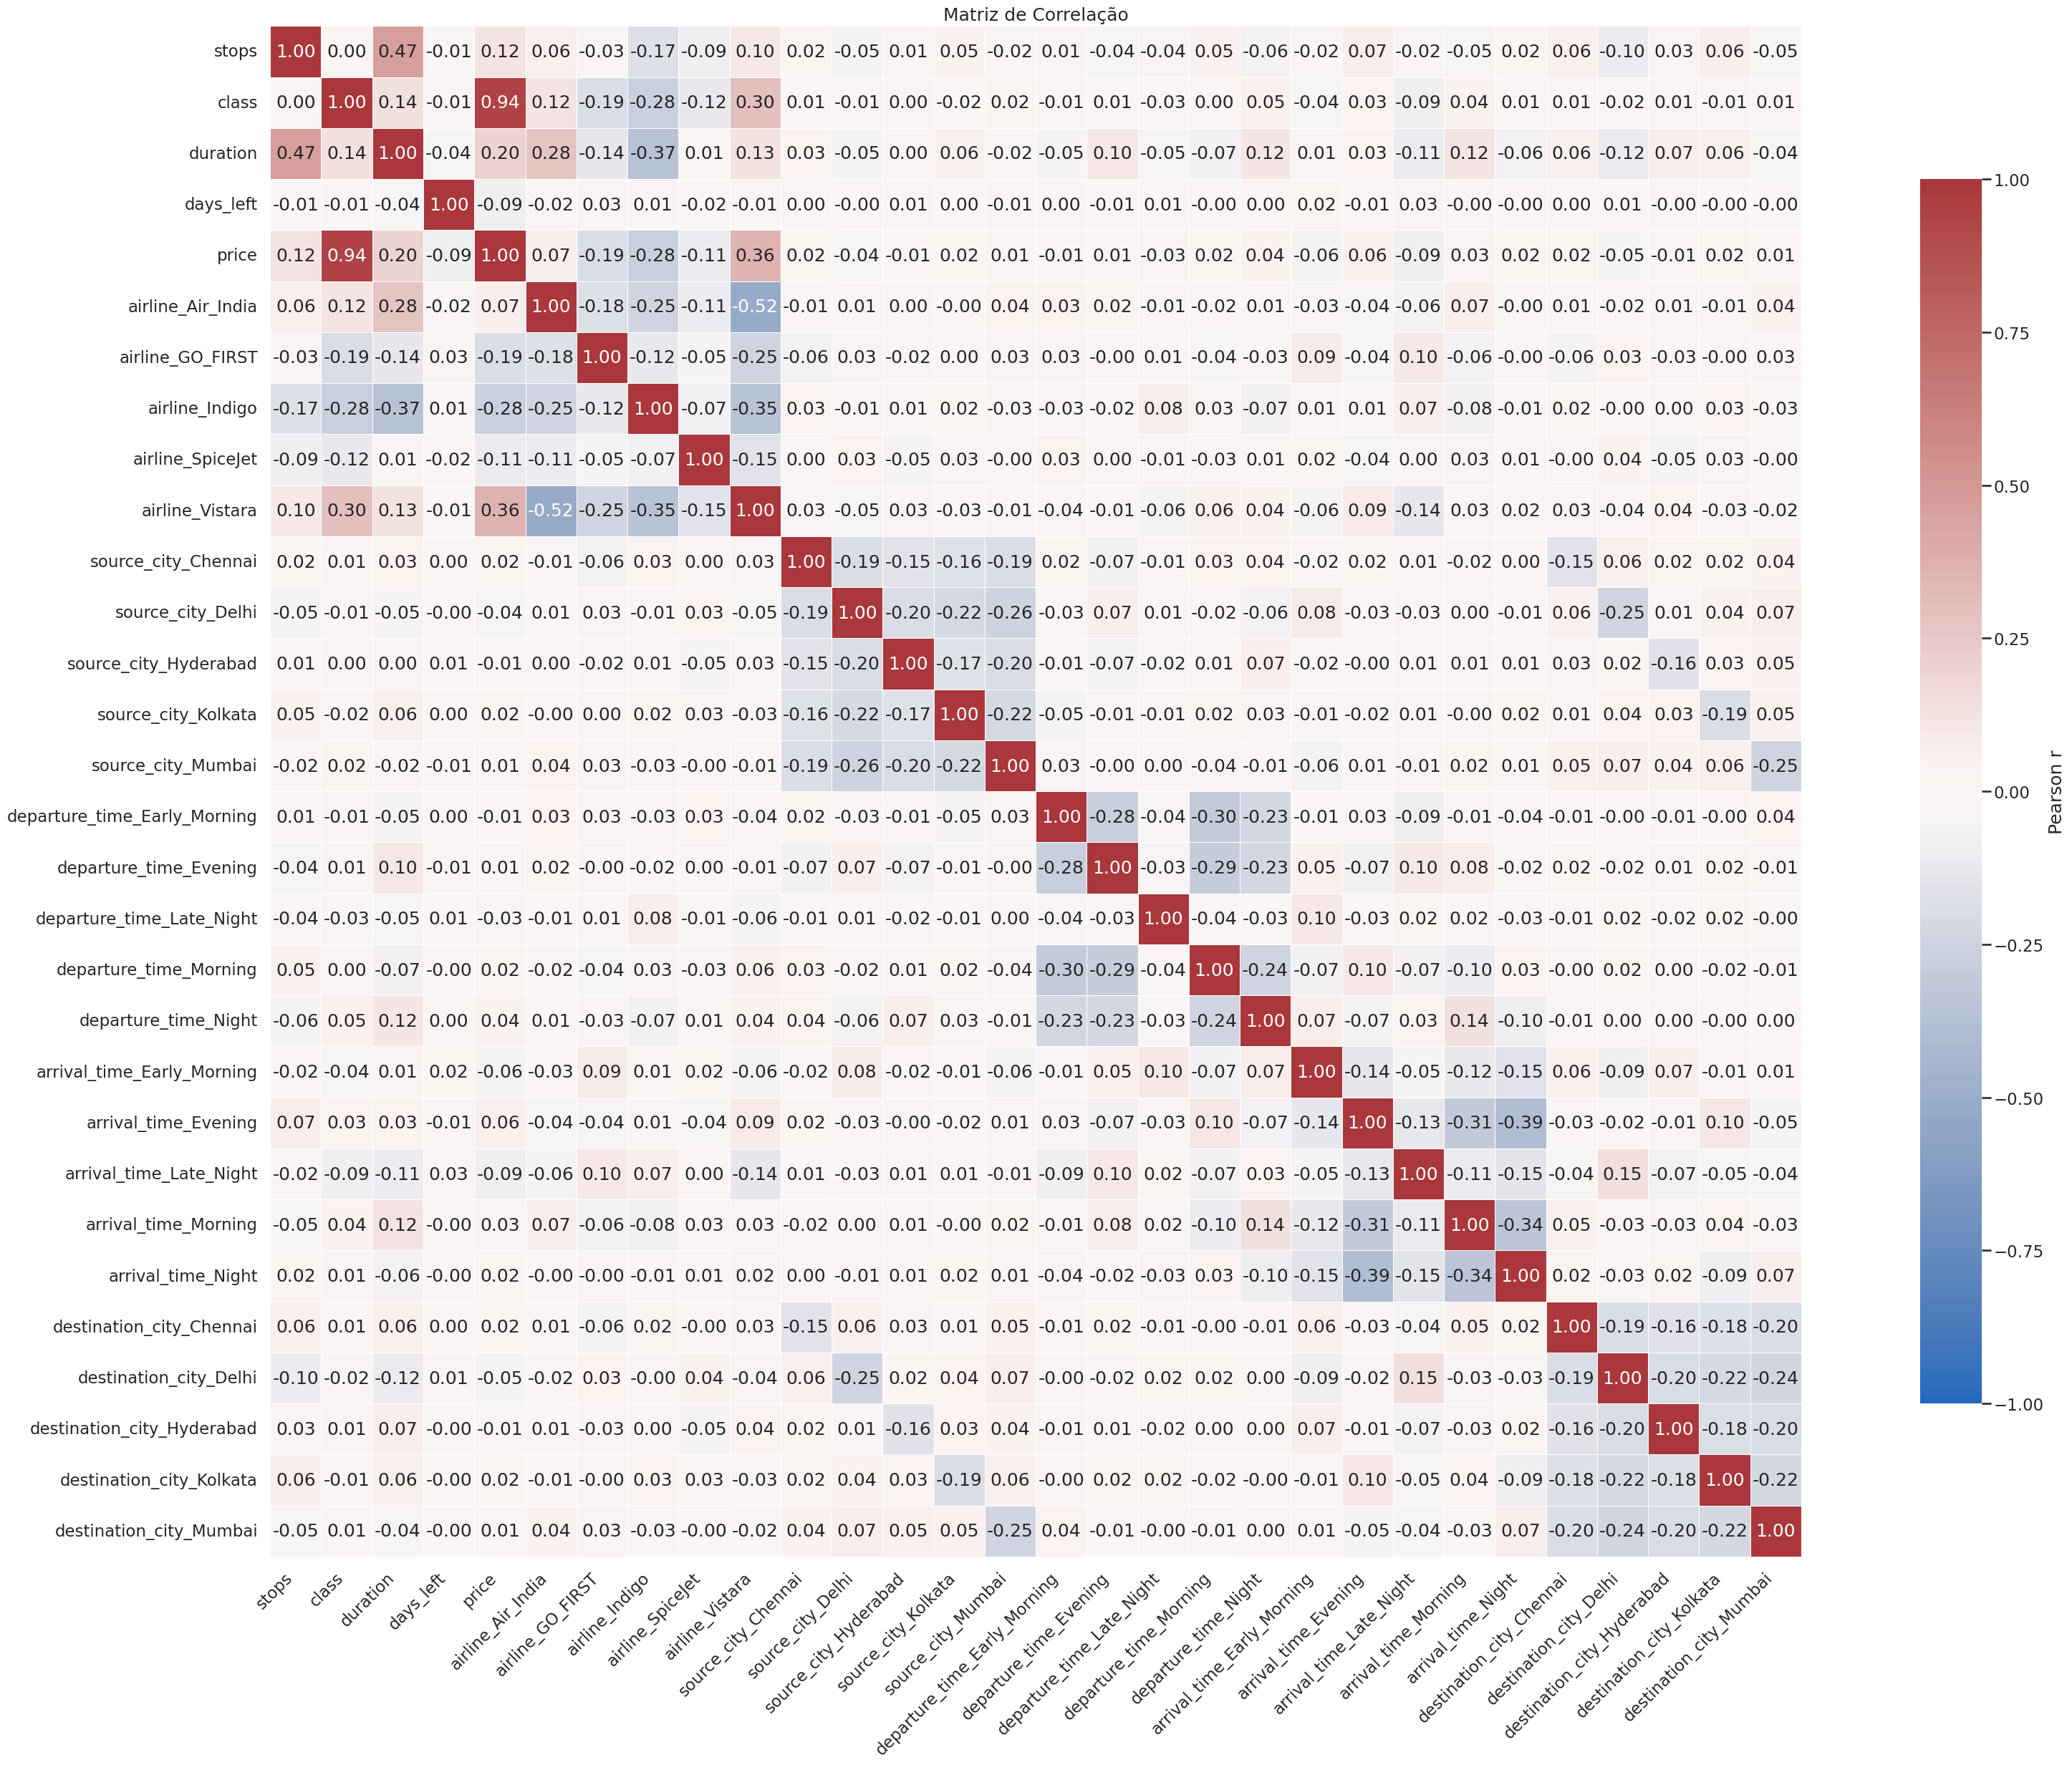

In [34]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(35, 25))
ax = sns.heatmap(
    corr,                      
    annot=True, fmt=".2f",
    vmin=-1.0, vmax=1.0, center=0,
    cmap="vlag",             
    square=True,
    linewidths=0.4, linecolor="white",
    cbar_kws={"shrink": 0.8, "label": "Pearson r"},
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Matriz de Correlação")
plt.tight_layout()
plt.show()

### Separação do conjunto de testes e treino

In [37]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
SEED = 42

y = df['price']
X = df.drop('price', axis=1)

In [38]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.30, random_state=SEED)
X_val,   X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=SEED)

print(f"Train ({(len(X_train)/len(X)):.2f}): {len(X_train)} | Val ({len(X_val)/len(X):.2f}): {len(X_val)} | Test ({len(X_test)/len(X):.2f}): {len(X_test)}")

Train (0.70): 210107 | Val (0.15): 45023 | Test (0.15): 45023


In [39]:
X_train

,stops,class,duration,days_left,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,...,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
2406,1,0,13.42,14,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
275865,1,1,9.58,23,False,False,False,False,True,False,...,False,True,False,False,False,False,True,False,False,False
297156,1,1,11.17,29,False,False,False,False,True,True,...,False,True,False,False,False,False,False,False,True,False
12826,1,0,5.08,16,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
93166,1,0,12.58,45,False,True,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,1,0,20.50,2,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
259178,1,1,25.42,7,False,False,False,False,True,False,...,False,False,False,False,True,True,False,False,False,False
131932,1,0,13.67,29,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
146867,1,0,8.33,39,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False


### Normalização das variáveis

In [40]:
# Scaling APÓS o split (sem tocar na variável-alvo)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_vars = ['duration', 'days_left']  # ⬅️ não inclui 'price'

# Ajusta no treino e aplica em val/test (sem vazamento)
X_train.loc[:, num_vars] = scaler.fit_transform(X_train[num_vars])
X_val.loc[:,   num_vars] = scaler.transform(X_val[num_vars])
X_test.loc[:,  num_vars] = scaler.transform(X_test[num_vars])

/tmp/ipykernel_87733/2227656102.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.27083333 0.45833333 0.58333333 ... 0.58333333 0.79166667 0.33333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, num_vars] = scaler.fit_transform(X_train[num_vars])
/tmp/ipykernel_87733/2227656102.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.20833333 0.875      0.27083333 ... 1.         1.         0.47916667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_val.loc[:,   num_vars] = scaler.transform(X_val[num_vars])
/tmp/ipykernel_87733/2227656102.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0625     0.5625     0.77083333 ... 0.25       0.10416667 0.64583333]' has dt

## Rede Neural Artificial

A rede neural artificial (ANN) implementada realiza uma **tarefa de regressão supervisionada**, com o objetivo de prever um valor contínuo (no caso, o preço da passagem aérea) a partir de **30 variáveis de entrada** previamente processadas.

O modelo foi construído do zero, utilizando apenas **NumPy**, sem o uso de frameworks de alto nível como TensorFlow ou PyTorch, o que permite controle total sobre o fluxo de cálculo e o aprendizado.

A arquitetura definida segue o padrão **feedforward totalmente conectado (Multilayer Perceptron – MLP)**, composta por:

* **Camada de entrada:** 30 neurônios (uma para cada feature numérica e categórica codificada).
* **1ª camada oculta:** 32 neurônios com função de ativação **ReLU (Rectified Linear Unit)**.
* **2ª camada oculta:** 16 neurônios, também com ativação ReLU.
* **Camada de saída:** 1 neurônio com **saída linear**, adequada para tarefas de regressão (onde o valor previsto é contínuo).


### Processo de Treinamento

O treinamento ocorre via **gradiente descendente estocástico** com o otimizador **Adam**, uma variação adaptativa que combina momentum e RMSProp para ajustar dinamicamente a taxa de aprendizado.

Os principais parâmetros adotados foram:

* **Taxa de aprendizado (`lr`)**: 0.001
* **Tamanho do batch (`batch size`)**: 128 amostras por atualização de gradiente
* **Número de épocas:** 100
* **Função de custo:** **Erro Quadrático Médio (MSE)**, apropriada para regressão.

Durante o treinamento:

1. O conjunto de treino é embaralhado e dividido em batches.
2. Para cada batch, é feita a **propagação direta (forward pass)** para gerar previsões.
3. O erro é calculado via MSE.
4. O erro é propagado para trás (**backpropagation**) para calcular os gradientes das camadas.
5. Os pesos e vieses são atualizados conforme as regras do **Adam**.

Ao final de cada época, o código também calcula a **loss de validação**, permitindo monitorar a generalização do modelo ao longo do tempo.

### Avaliação e Resultados

Após o treinamento, o modelo foi avaliado nos conjuntos de **validação** e **teste**, com as métricas:

* **MAE (Mean Absolute Error)**
* **RMSE (Root Mean Squared Error)**
* **R² (Coeficiente de Determinação)**

Os resultados obtidos mostram um modelo com **erro médio relativamente baixo** e **alto coeficiente de determinação (R² ≈ 0.96)**, indicando que a rede aprendeu bem as relações entre as variáveis de entrada e o preço.

Além disso, foram gerados dois gráficos principais:

* **Curva de loss (MSE)** para treino e validação, evidenciando a convergência do modelo.
* **Dispersão entre valores reais e previstos (y_true vs y_pred)**, mostrando boa correlação e baixa dispersão residual.

Época 01 | Train MSE 678509857.4816 | Val MSE 398164542.4253
Época 02 | Train MSE 326570275.8006 | Val MSE 248977535.9151
Época 03 | Train MSE 167966263.4366 | Val MSE 95650901.6718
Época 04 | Train MSE 62077396.4720 | Val MSE 47291686.2173
Época 05 | Train MSE 42988600.4069 | Val MSE 42002038.3514
Época 06 | Train MSE 39708288.1543 | Val MSE 39712292.8742
Época 07 | Train MSE 37961861.7792 | Val MSE 38414171.9839
Época 08 | Train MSE 36873997.5994 | Val MSE 37462698.1271
Época 09 | Train MSE 36046750.1699 | Val MSE 36682944.0764
Época 10 | Train MSE 35317419.2662 | Val MSE 35993500.8448
Época 11 | Train MSE 34632413.1965 | Val MSE 35377141.7630
Época 12 | Train MSE 34014803.2772 | Val MSE 34735166.3910
Época 13 | Train MSE 33459533.5891 | Val MSE 34206057.7083
Época 14 | Train MSE 32954468.3794 | Val MSE 33734255.0602
Época 15 | Train MSE 32493218.0879 | Val MSE 33285006.0355
Época 16 | Train MSE 32073442.7710 | Val MSE 32837303.2367
Época 17 | Train MSE 31692858.1649 | Val MSE 324758

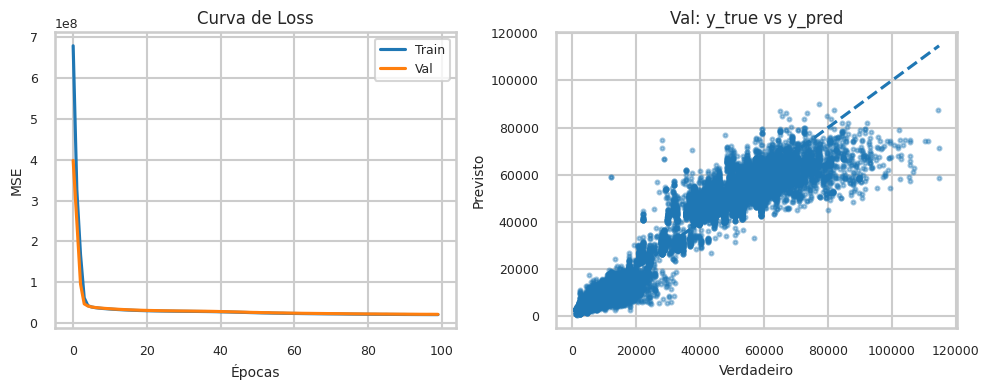

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

X_train_base = X_train   
X_val_base = X_val   
X_test_base = X_test

X_train = np.asarray(X_train_base, dtype=float)
X_val   = np.asarray(X_val_base,   dtype=float)
X_test  = np.asarray(X_test_base,  dtype=float)

y_train = np.asarray(y_train, dtype=float).ravel()
y_val   = np.asarray(y_val,   dtype=float).ravel()
y_test  = np.asarray(y_test,  dtype=float).ravel()

y_train_col = y_train.reshape(-1, 1)
y_val_col   = y_val.reshape(-1, 1)

N, D = X_train.shape

# 1) Métricas de regressão
def metrics(y_true, y_pred):
    y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = sqrt(np.mean((y_true - y_pred)**2))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# 2) Arquitetura: ReLU 128→64→1 (linear)
rng = np.random.default_rng(42)
H1, H2 = 32, 16

W1 = rng.standard_normal((H1, D)) * np.sqrt(2.0 / D)
b1 = np.zeros((1, H1))

W2 = rng.standard_normal((H2, H1)) * np.sqrt(2.0 / H1) 
b2 = np.zeros((1, H2))

W3 = rng.standard_normal((1, H2)) * np.sqrt(2.0 / H2)
b3 = np.zeros((1, 1))

def relu(x):    
    return np.maximum(0, x)

def relu_d(x):  
    return (x > 0).astype(x.dtype)

def forward(X):
    Z1 = X @ W1.T + b1; A1 = relu(Z1)
    Z2 = A1 @ W2.T + b2; A2 = relu(Z2)
    Y  = A2 @ W3.T + b3          # saída linear (regressão)
    return Z1, A1, Z2, A2, Y

# 3) Treino: Adam + MSE
lr = 1e-3
epochs = 100
batch  = 128

beta1, beta2, eps = 0.9, 0.999, 1e-8

# Adam buffers
mW1 = np.zeros_like(W1) 
vW1 = np.zeros_like(W1)

mW2 = np.zeros_like(W2)
vW2 = np.zeros_like(W2)

mW3 = np.zeros_like(W3)
vW3 = np.zeros_like(W3)

mb1 = np.zeros_like(b1)
vb1 = np.zeros_like(b1)

mb2 = np.zeros_like(b2) 
vb2 = np.zeros_like(b2)

mb3 = np.zeros_like(b3)
vb3 = np.zeros_like(b3)

t = 0

def adam_update(param, grad, m, v):
    m = beta1*m + (1-beta1)*grad
    v = beta2*v + (1-beta2)*(grad*grad)
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    param -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return param, m, v

train_losses, val_losses = [], []

for ep in range(1, epochs+1):
    idx = rng.permutation(N)
    epoch_loss = 0.0

    for i in range(0, N, batch):
        bidx = idx[i:i+batch]
        xb = X_train[bidx]
        yb = y_train_col[bidx]
        B  = xb.shape[0]

        #  forward 
        Z1, A1, Z2, A2, Yp = forward(xb)

        #  loss (MSE)
        mse = np.mean((Yp - yb)**2)
        epoch_loss += mse * B

        #  backprop 
        d3  = (2.0/B) * (Yp - yb)     # (B,1)
        gW3 = d3.T @ A2               # (1,H2)
        gb3 = d3.sum(axis=0, keepdims=True)

        dA2 = d3 @ W3                 # (B,H2)
        dZ2 = dA2 * relu_d(Z2)
        gW2 = dZ2.T @ A1              # (H2,H1)
        gb2 = dZ2.sum(axis=0, keepdims=True)

        dA1 = dZ2 @ W2                # (B,H1)
        dZ1 = dA1 * relu_d(Z1)
        gW1 = dZ1.T @ xb              # (H1,D)
        gb1 = dZ1.sum(axis=0, keepdims=True)

        #  Adam step (incrementa t uma vez por batch) 
        t += 1
        W3, mW3, vW3 = adam_update(W3, gW3, mW3, vW3)
        b3, mb3, vb3 = adam_update(b3, gb3, mb3, vb3)
        W2, mW2, vW2 = adam_update(W2, gW2, mW2, vW2)
        b2, mb2, vb2 = adam_update(b2, gb2, mb2, vb2)
        W1, mW1, vW1 = adam_update(W1, gW1, mW1, vW1)
        b1, mb1, vb1 = adam_update(b1, gb1, mb1, vb1)

    epoch_loss /= N
    train_losses.append(epoch_loss)

    # validação
    _, _, _, _, Yv = forward(X_val)
    val_mse = np.mean((Yv - y_val_col)**2)
    val_losses.append(val_mse)

    print(f"Época {ep:02d} | Train MSE {epoch_loss:.4f} | Val MSE {val_mse:.4f}")

# 4) Avaliação e gráficos
def predict(X):
    _, _, _, _, Y = forward(X)
    return Y.ravel()

pred_val  = predict(X_val)
pred_test = predict(X_test)

print("Val :", metrics(y_val,  pred_val))
print("Test:", metrics(y_test, pred_test))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses,   label="Val")
plt.xlabel("Épocas"); plt.ylabel("MSE"); plt.title("Curva de Loss"); plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_val, pred_val, s=8, alpha=0.4)
lims = [min(y_val.min(), pred_val.min()), max(y_val.max(), pred_val.max())]
plt.plot(lims, lims, "--")
plt.xlabel("Verdadeiro"); plt.ylabel("Previsto"); plt.title("Val: y_true vs y_pred")
plt.tight_layout(); plt.show()

### Visualizção dos resultados


=== Validation ===
Metric           Model         Baseline(mean y_train)
MAE      :    2719.2841   19825.9131
MSE      :   21706152.6864   519108303.5968
RMSE     :    4658.9862   22783.9484
R2       :       0.9582      -0.0000
MAPE(%)  :      20.3035     238.0368
sMAPE(%) :      18.8756     101.0205

=== Test ===
Metric           Model         Baseline(mean y_train)
MAE      :    2702.1777   19702.5628
MSE      :   20740489.7360   510225579.3527
RMSE     :    4554.1728   22588.1734
R2       :       0.9593      -0.0000
MAPE(%)  :      20.5237     239.3193
sMAPE(%) :      19.0806     100.9381


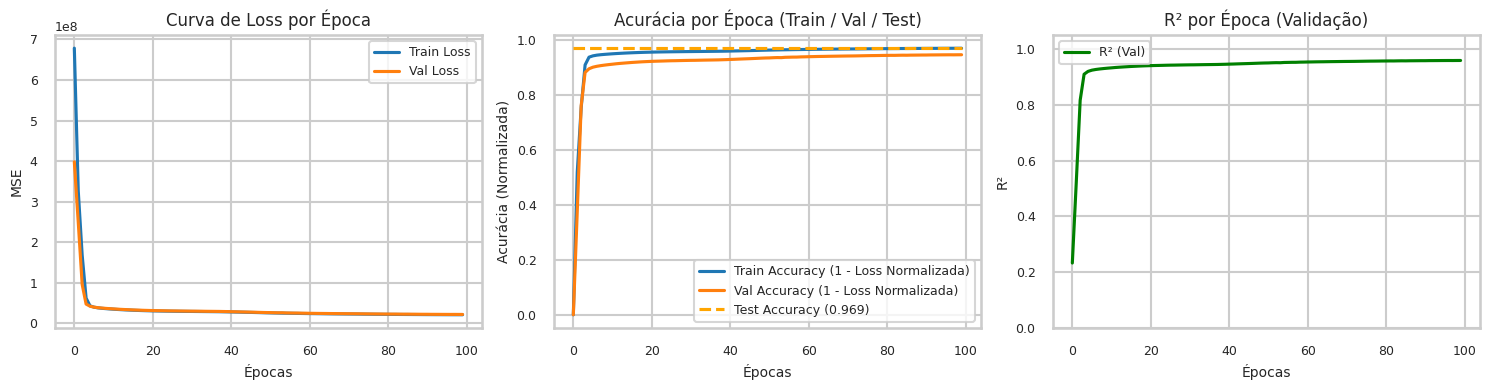

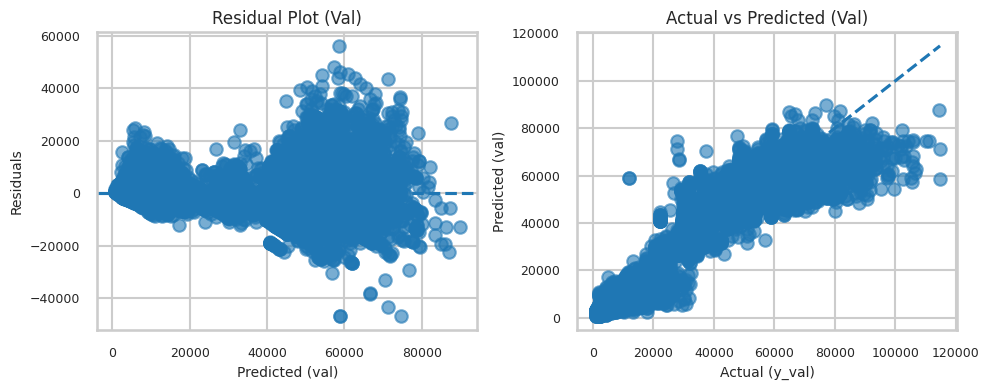

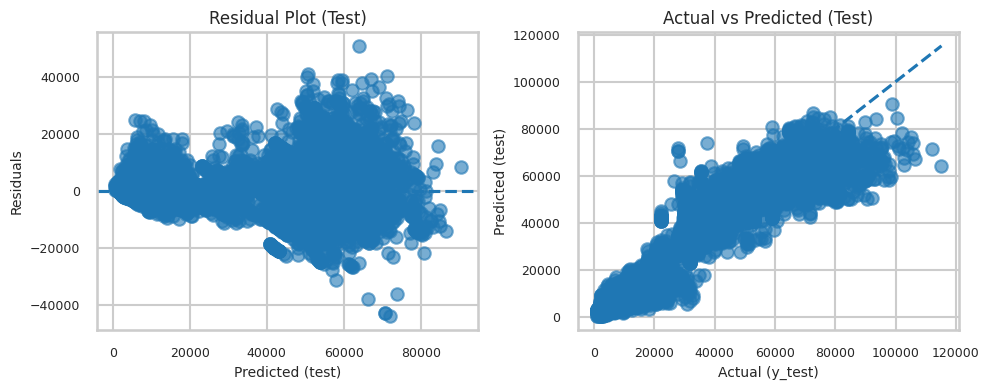

In [55]:
from math import sqrt
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.titlesize": 13
})

# Funções auxiliares de métricas
def _to1d(a):
    a = np.asarray(a, dtype=float)
    return a.ravel() if a.ndim > 1 else a

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum((np.abs(y_true) + np.abs(y_pred)) / 2, eps)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100.0

def r2_score_np(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

# Dados e previsões
X_val   = np.asarray(X_val, dtype=float)
X_test  = np.asarray(X_test, dtype=float)
y_train = _to1d(y_train)
y_val   = _to1d(y_val)
y_test  = _to1d(y_test)

y_pred_val  = _to1d(predict(X_val))
y_pred_test = _to1d(predict(X_test))

baseline_val  = np.full_like(y_val,  fill_value=float(np.mean(y_train)), dtype=float)
baseline_test = np.full_like(y_test, fill_value=float(np.mean(y_train)), dtype=float)

# Função de métricas gerais
def print_metrics(title, y_true, y_pred, y_base):
    mae  = np.mean(np.abs(y_true - y_pred))
    mse  = np.mean((y_true - y_pred)**2)
    rmse = sqrt(mse)
    r2   = r2_score_np(y_true, y_pred)
    mp   = mape(y_true, y_pred)
    smp  = smape(y_true, y_pred)

    mae_b  = np.mean(np.abs(y_true - y_base))
    mse_b  = np.mean((y_true - y_base)**2)
    rmse_b = sqrt(mse_b)
    r2_b   = r2_score_np(y_true, y_base)
    mp_b   = mape(y_true, y_base)
    smp_b  = smape(y_true, y_base)

    print(f"\n=== {title} ===")
    print("Metric           Model         Baseline(mean y_train)")
    print(f"MAE      :   {mae:10.4f}   {mae_b:10.4f}")
    print(f"MSE      :   {mse:10.4f}   {mse_b:10.4f}")
    print(f"RMSE     :   {rmse:10.4f}   {rmse_b:10.4f}")
    print(f"R2       :   {r2:10.4f}   {r2_b:10.4f}")
    print(f"MAPE(%)  :   {mp:10.4f}   {mp_b:10.4f}")
    print(f"sMAPE(%) :   {smp:10.4f}   {smp_b:10.4f}")

print_metrics("Validation", y_val,  y_pred_val,  baseline_val)
print_metrics("Test",       y_test, y_pred_test, baseline_test)

# ------------------------------------------------------------
train_acc = 1 - np.array(train_losses) / np.max(train_losses)
val_acc   = 1 - np.array(val_losses) / np.max(val_losses)

ss_tot_val = np.sum((y_val - np.mean(y_val))**2)
r2_by_epoch = [1 - (mse * len(y_val)) / ss_tot_val for mse in val_losses]

final_mse_test = np.mean((y_pred_test - y_test)**2)
test_acc = 1 - final_mse_test / np.max(train_losses)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Épocas"); plt.ylabel("MSE")
plt.title("Curva de Loss por Época")
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_acc, label="Train Accuracy (1 - Loss Normalizada)")
plt.plot(val_acc, label="Val Accuracy (1 - Loss Normalizada)")
plt.hlines(test_acc, 0, len(train_acc)-1, colors='orange', linestyles='--', label=f"Test Accuracy ({test_acc:.3f})")
plt.xlabel("Épocas"); plt.ylabel("Acurácia (Normalizada)")
plt.title("Acurácia por Época (Train / Val / Test)")
plt.legend()

plt.subplot(1,3,3)
plt.plot(r2_by_epoch, color='green', label="R² (Val)")
plt.xlabel("Épocas"); plt.ylabel("R²")
plt.title("R² por Época (Validação)")
plt.ylim(0, 1.05)
plt.legend()

plt.tight_layout()
plt.show()

# 2) Gráficos de resíduos e previsão x real
res_val = y_val - y_pred_val
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_pred_val, res_val, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted (val)"); plt.ylabel("Residuals")
plt.title("Residual Plot (Val)")

plt.subplot(1,2,2)
plt.scatter(y_val, y_pred_val, alpha=0.6)
mn = float(min(np.min(y_val), np.min(y_pred_val)))
mx = float(max(np.max(y_val), np.max(y_pred_val)))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("Actual (y_val)"); plt.ylabel("Predicted (val)")
plt.title("Actual vs Predicted (Val)")
plt.tight_layout()
plt.show()

res_test = y_test - y_pred_test
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_pred_test, res_test, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted (test)"); plt.ylabel("Residuals")
plt.title("Residual Plot (Test)")

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_test, alpha=0.6)
mn = float(min(np.min(y_test), np.min(y_pred_test)))
mx = float(max(np.max(y_test), np.max(y_pred_test)))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("Actual (y_test)"); plt.ylabel("Predicted (test)")
plt.title("Actual vs Predicted (Test)")
plt.tight_layout()
plt.show()


## Conclusões

Foram analisadas as curvas de treinamento, as métricas de regressão e os gráficos de desempenho do modelo de rede neural aplicado à predição do preço de passagens aéreas.

Durante o treinamento, as curvas de **loss (MSE)** de treino e validação apresentaram queda acentuada nas primeiras épocas e estabilização progressiva a partir da 80ª época, indicando **convergência** e ausência de overfitting. As curvas de treino e validação mantêm-se próximas, o que evidencia **boa generalização** do modelo. O gráfico de **R² por época** confirma essa estabilidade, atingindo valores próximos de **0,96**, o que mostra que o modelo explica cerca de 96% da variabilidade dos preços.

Os **gráficos de resíduos (Residual Plots)** e **Actual vs Predicted** indicam uma **forte correlação** entre valores reais e previstos, com os pontos bem distribuídos ao longo da linha de referência. Há, contudo, **ligeiro aumento da dispersão para preços mais altos**, o que sugere **heterocedasticidade** — isto é, erros ligeiramente maiores em passagens mais caras, um comportamento esperado em dados econômicos.

As **métricas de regressão** confirmam a boa performance do modelo em relação ao baseline (previsão pela média do treino):

| Métrica       | Validação (Modelo / Baseline) | Teste (Modelo / Baseline) |
| ------------- | ----------------------------- | ------------------------- |
| **MAE**       | 2.719 / 19.826                | 2.702 / 19.703            |
| **MSE**       | 21.706.152 / 519.108.303      | 20.740.489 / 510.225.579  |
| **RMSE**      | 4.659 / 22.783                | 4.554 / 22.588            |
| **R²**        | 0.958                         | 0.959                     |
| **MAPE (%)**  | 20.30 / 238.03                | 20.52 / 239.31            |
| **sMAPE (%)** | 18.88 / 101.02                | 19.08 / 100.94            |

Os resultados mostram que a rede neural **supera amplamente o baseline**, apresentando erros absolutos e percentuais significativamente menores e um **R² elevado**, o que evidencia um **modelo robusto e bem ajustado**.

Em síntese:

* O modelo apresenta **excelente capacidade preditiva e estabilidade**, com erro médio (MAE) em torno de 2.700 unidades monetárias e erro percentual próximo de 20%.
* As curvas e o R² mostram **convergência estável e boa generalização**.
* Pequenos desvios para valores altos de preço indicam espaço para aprimoramentos, como aplicar transformações no alvo (`log(price)`) ou empregar **funções de perda mais robustas** (MAE ou Huber).
* O desempenho geral demonstra que a arquitetura da rede foi **adequada para capturar padrões complexos** no comportamento dos preços de passagens aéreas.


OBS: Fizemos uma métrica de acurácia baseada no MSE, esta métrica foi criada simplesmente pois na página da disciplina, que descreve o projeto, pede um gráfico de acurácia por época.
